# Bayesian analysis of the second MTurk Experiment (Feb. 2019)

The goal is to use an ANOVA / ANCOVA style analysis for the experiments; it is possible that the metadata collected (income, education level) play a moderating role. A weakness is that since these are self reported, they may contain substantial noise.

In [36]:
# %load std_ipython_import.txt
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm

import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import norm
from scipy.stats import t as studentT
from scipy import linalg, sparse

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')
color = '#87ceeb'

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Gill Sans MT']

from matplotlib import rc
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

# Data

In [3]:
# Using dtype 'category' for Y

df = pd.read_csv(
    'data/cs_final.csv'
    #     dtype={
    #         'y': 'int',
    #         'gesture': 'int',
    #         'dist': 'int',
    #         'shading': 'int',
    #         'cond': 'int',
    #         'comicleft': 'int'
    #     }
)

df.rename(
    columns={
        'Q9': 'education',
        'Q8': 'income',
        'Q7': 'gender',
        'text_donation': 'text',
        'comic_donation': 'comic',
        'socialnorm_donation': 'social'
    },
    inplace=True)
# df.info()
dfs = pd.DataFrame()

In [4]:
# adding the response and condition columns
df['condition'] = 0
df.loc[df.text>=0, ['condition']] = "text"
df.loc[df.social>=0, ['condition']] = "comic+social"
df.loc[df.comic>=0, ['condition']] = "comic"

df['response'] = 0
df.loc[df.text>=0, ['response']] = df.text[df.text>=0]
df.loc[df.social>=0, ['response']] = df.social[df.social>=0]
df.loc[df.comic>=0, ['response']] = df.comic[df.comic>=0]

## helper functions from DBDA-Python

https://github.com/JWarmenhoven/DBDA-python

In [21]:
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma


def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt(mode**2 + 4 * sd**2)) / (2 * sd**2)
    shape = 1 + mode * rate
    return (shape, rate)

In [22]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=color, alpha=.6)

In [23]:
def plot_cred_lines(b0, bj, bcov, x, ax):
    """Plot credible posterior distribution lines for model in section 19.4"""

    B = pd.DataFrame(
        np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])

    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0, :])
              & B.betaj.between(*hpd_interval[1, :]) &
              B.betacov.between(*hpd_interval[2, :])]
    xrange = np.linspace(x.min() * .95, x.max() * 1.05)

    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(
            xrange,
            B_hpd.iloc[i, 0] + B_hpd.iloc[i, 1] + B_hpd.iloc[i, 2] * xrange,
            c=color,
            alpha=.6,
            zorder=0)

## back to our analysis

In [8]:
# doing all three cases together
m_mean = np.zeros(3)
m_mean[0] = np.mean(df[df.condition=="text"].response)
m_mean[1] = np.mean(df[df.condition=="comic"].response)
m_mean[2] = np.mean(df[df.condition=="comic+social"].response)

m_std = np.zeros(3)
m_std[0] = np.std(df[df.condition=="text"].response)
m_std[1] = np.std(df[df.condition=="comic"].response)
m_std[2] = np.std(df[df.condition=="comic+social"].response)

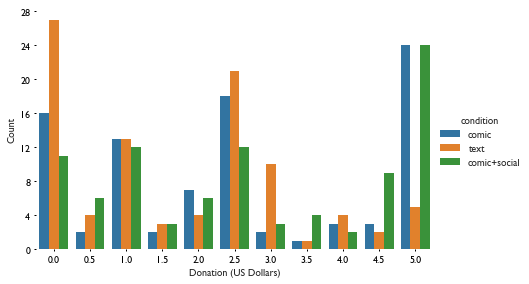

In [9]:
g = sb.catplot(
    hue="condition", data=df, height=4, x="response", kind="count",
    aspect=1.5).set(yticks=np.arange(0, 30, 4)).set_axis_labels(
        "Donation (US Dollars)", "Count")
g.axes[0, 0].tick_params(
    direction='out', length=2, width=1, colors='k', which='major')
g.despine(offset=20, left=True, bottom=True)
g.savefig("contributions across conditions.pdf")

## Defining the model

We have three different groups, who are randomly assigned to text, comic, comic+social conditions. The outcome variable is the degree of contribution. Thus, we have an ANOVA style situation, where we have a metric predicted variable, with a nominal (i.e. the group index) predictor.

We model it as a student-t distribution; the number of degrees of freedom is obtained from an exponential distribution $\nu \sim \exp(-\lambda)$; the mode $\mu \sim \mathcal{N}(a,b)$, spread $\sigma \sim U(L,H)$



In [10]:
# Count the number of records per nominal group
df['condition'] = df['condition'].astype('category')
df.condition.value_counts()

text            94
comic+social    92
comic           91
Name: condition, dtype: int64

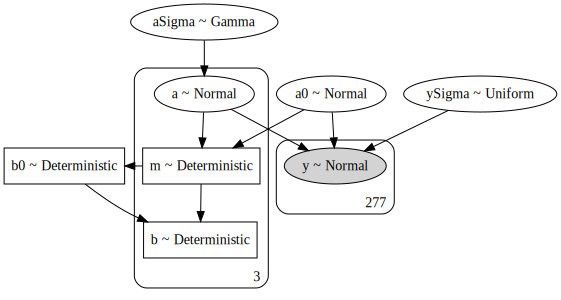

In [11]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

# this model assumes normality
with pm.Model() as model1:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 
    
pm.model_to_graphviz(model1)

In [12]:
with model1:
    trace1 = pm.sample(5000,nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ySigma, a, a0, aSigma]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:37<00:00, 580.13draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [13]:
print(pm.diagnostics.gelman_rubin(trace1))
print("effective sample size", pm.diagnostics.effective_n(trace1))

{'a0': 1.0033298348961015, 'a': array([1.00338429, 1.00329536, 1.00346247]), 'aSigma': 1.0002210368506317, 'ySigma': 1.0001908135990134, 'm': array([0.99993088, 1.00011569, 0.99998711]), 'b0': 1.0000011883753852, 'b': array([0.99993692, 1.00010264, 1.00000932])}
effective sample size {'a0': 1466.0740285464447, 'a': array([1483.34586349, 1485.56541291, 1452.79931622]), 'aSigma': 2628.9178491715884, 'ySigma': 8795.060819252081, 'm': array([23312.94113698, 19880.8342958 , 18527.87333543]), 'b0': 22174.818844039364, 'b': array([22989.70196736, 19392.6225163 , 17376.12672855])}


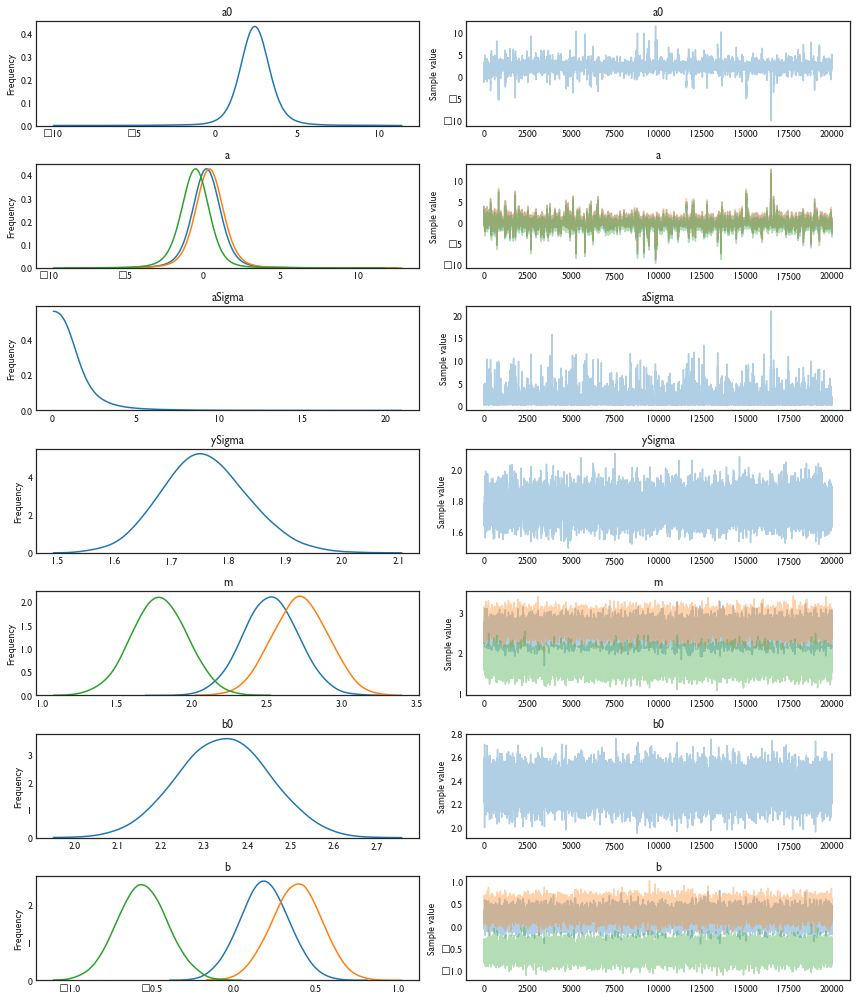

In [119]:
pm.traceplot(trace1, combined=True);

## analysing the model parameters

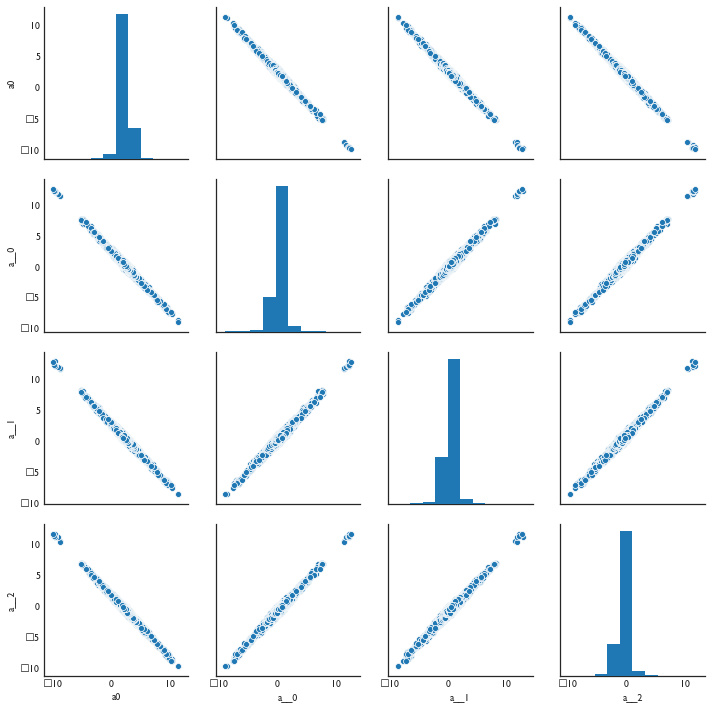

In [85]:
tracedf1 = pm.trace_to_dataframe(trace1, varnames=['a0', 'a'])
sb.pairplot(tracedf1);

In [83]:
vals = np.array([model1.dict_to_array(v) for v in trace1[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = linalg.svd(vals)

In [84]:
len(S)

6

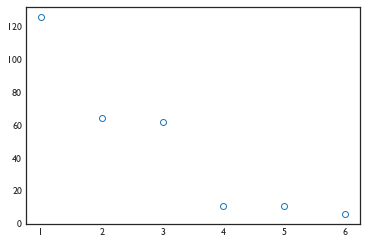

In [81]:
sb.mpl.pyplot.plot(np.arange(1, len(S)+1), S, 'o', mfc='w', mew=1)

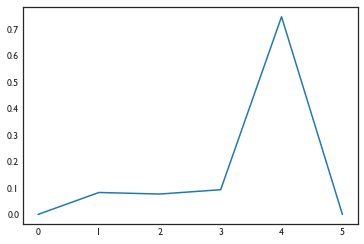

In [80]:
plt.plot(U[:, -1] ** 2)


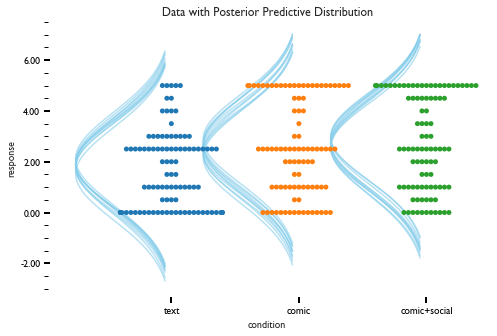

In [15]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = trace1['m'][:, 0]
social = trace1['m'][:, 1]
text = trace1['m'][:, 2]
scale = trace1['ySigma'][:]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

# sb.violinplot(
#     'condition',
#     'response',
#     split=True,
#     data=df,
#     order=["text","comic", "comic+social"],
#     inner=None,
#     ax=ax)

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["text","comic", "comic+social"],
#     color="white",
#     edgecolor="gray",
    ax=ax)
ax.set_xlim(xmin=-1)

for i, grp in enumerate([text, comic, social]):
    plot_mustache(grp, scale, i, ax)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("data, with basic ANOVA-like posterior predictions.pdf")

## contrasts

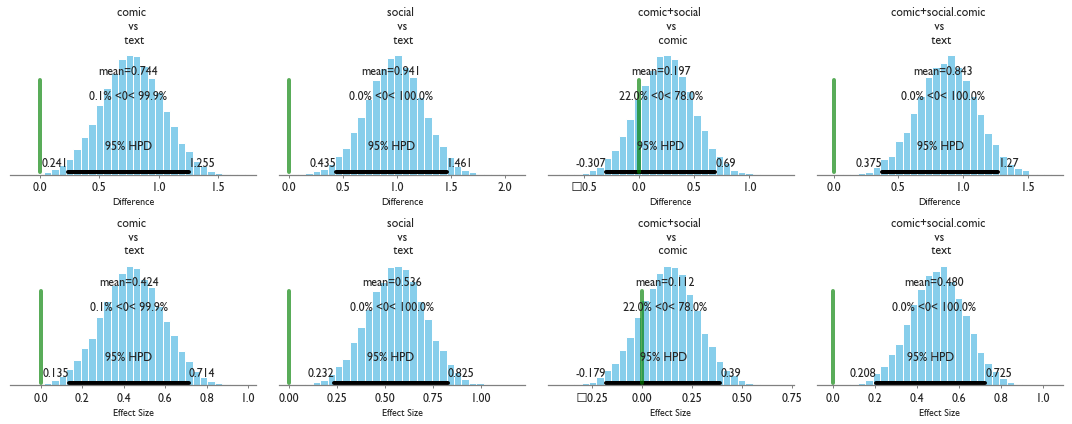

In [16]:
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

fig, axes = plt.subplots(2, 4, figsize=(15, 6))

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

contrast_titles = [
    'comic \n vs \n text',
    'social \n vs \n text', 
    'comic+social \n vs \n comic',
    'comic+social.comic \n vs \n text'
]

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr / scale, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()
fig.savefig("basic, anova-like case.pdf")

## case with unequal variances

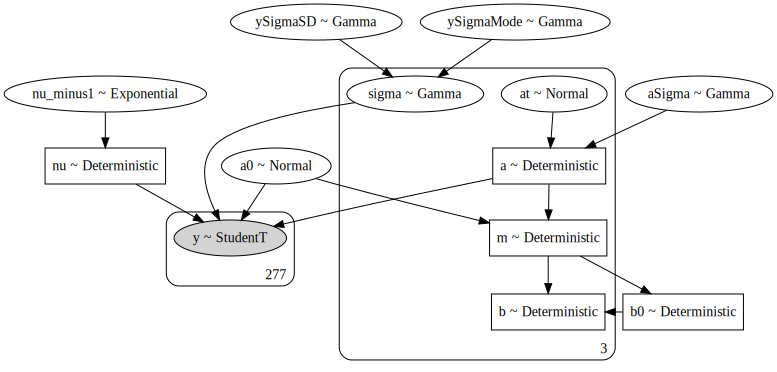

In [101]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as model3:
    
    aSigma = pm.Gamma('aSigma', aGammaShRa[0], aGammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a_t = pm.Normal('at', mu=0, sd=1, shape=NxLvl)
#     a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    a = pm.Deterministic('a', 0.0 + aSigma * a_t) # reparameterization
    
    ySigmaSD = pm.Gamma('ySigmaSD', aGammaShRa[0], aGammaShRa[1])
    ySigmaMode = pm.Gamma('ySigmaMode', aGammaShRa[0], aGammaShRa[1])
    ySigmaRa = (ySigmaMode + np.sqrt(ySigmaMode**2 + 4*ySigmaSD**2))/2*ySigmaSD**2
    ySigmaSh = ySigmaMode*ySigmaRa
        
    ySigma = pm.Gamma('sigma', ySigmaSh, ySigmaRa, shape=NxLvl)
#     ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
    nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
    nu = pm.Deterministic('nu', nu_minus1+1)
    like = pm.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma[x], observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0)

pm.model_to_graphviz(model3)

In [111]:
with model3:
    # Initializing NUTS with advi since jitter seems to create a problem in this model.
    # https://github.com/pymc-devs/pymc3/issues/2897
#     trace3 = pm.sample(3000, init='advi+adapt_diag', cores=4, nuts_kwargs={'target_accept': 0.95})
    trace3 = pm.sample(5000,init='advi+adapt_diag', nuts_kwargs={'target_accept': 0.95} )
#     trace3 = pm.sample(5000, nuts_kwargs={'target_accept': 0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 568.21:   8%|▊         | 15199/200000 [00:09<01:49, 1680.58it/s]
Convergence achieved at 15200
Interrupted at 15,199 [7%]: Average Loss = 949.22
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, ySigmaMode, ySigmaSD, at, a0, aSigma]
Sampling 4 chains: 100%|██████████| 22000/22000 [01:23<00:00, 264.79draws/s]
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [108]:
print(pm.diagnostics.gelman_rubin(trace3))
print("effective sample size", pm.diagnostics.effective_n(trace3))

{'a0': 1.0015892025482118, 'at': array([1.00058136, 1.00016223, 1.00012729]), 'aSigma': 1.0032771363666904, 'a': array([1.00187354, 1.00143047, 1.00202563]), 'ySigmaSD': 1.0019444711532475, 'ySigmaMode': 1.000409343216717, 'sigma': array([0.99968819, 1.00049462, 1.00027538]), 'nu_minus1': 0.9996638770056868, 'nu': 0.9996638770056868, 'm': array([0.99988387, 0.99966259, 1.00034066]), 'b0': 1.0001762532849447, 'b': array([0.9996271 , 1.00001491, 0.99981249])}
effective sample size {'a0': 575.565946571546, 'at': array([1436.43651459, 1416.37997982, 1168.81010247]), 'aSigma': 762.636128937379, 'a': array([585.49896605, 592.0497692 , 575.73800973]), 'ySigmaSD': 679.7044281107941, 'ySigmaMode': 1313.7754417104704, 'sigma': array([2046.16362935, 1619.56021862, 1890.09263664]), 'nu_minus1': 2469.841160011242, 'nu': 2469.841160011242, 'm': array([3426.79534395, 3748.51597041, 3095.41344127]), 'b0': 3516.043164467345, 'b': array([3753.23526312, 3801.76847317, 2880.89686908])}


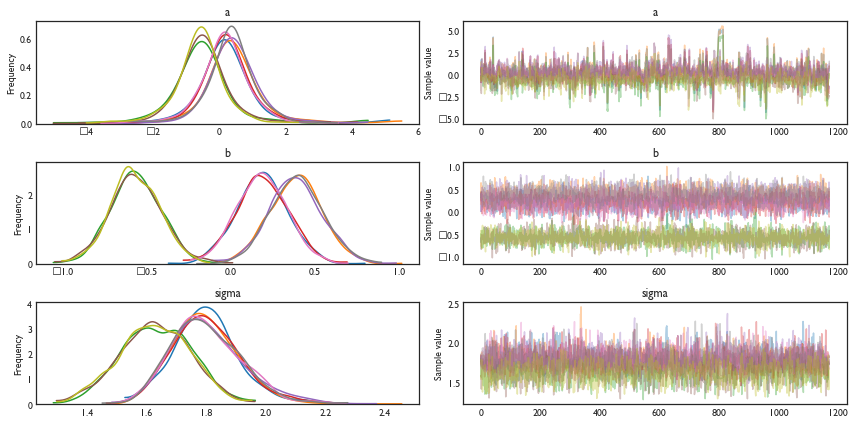

In [109]:
pm.traceplot(trace3, varnames=['a', 'b', 'sigma']);

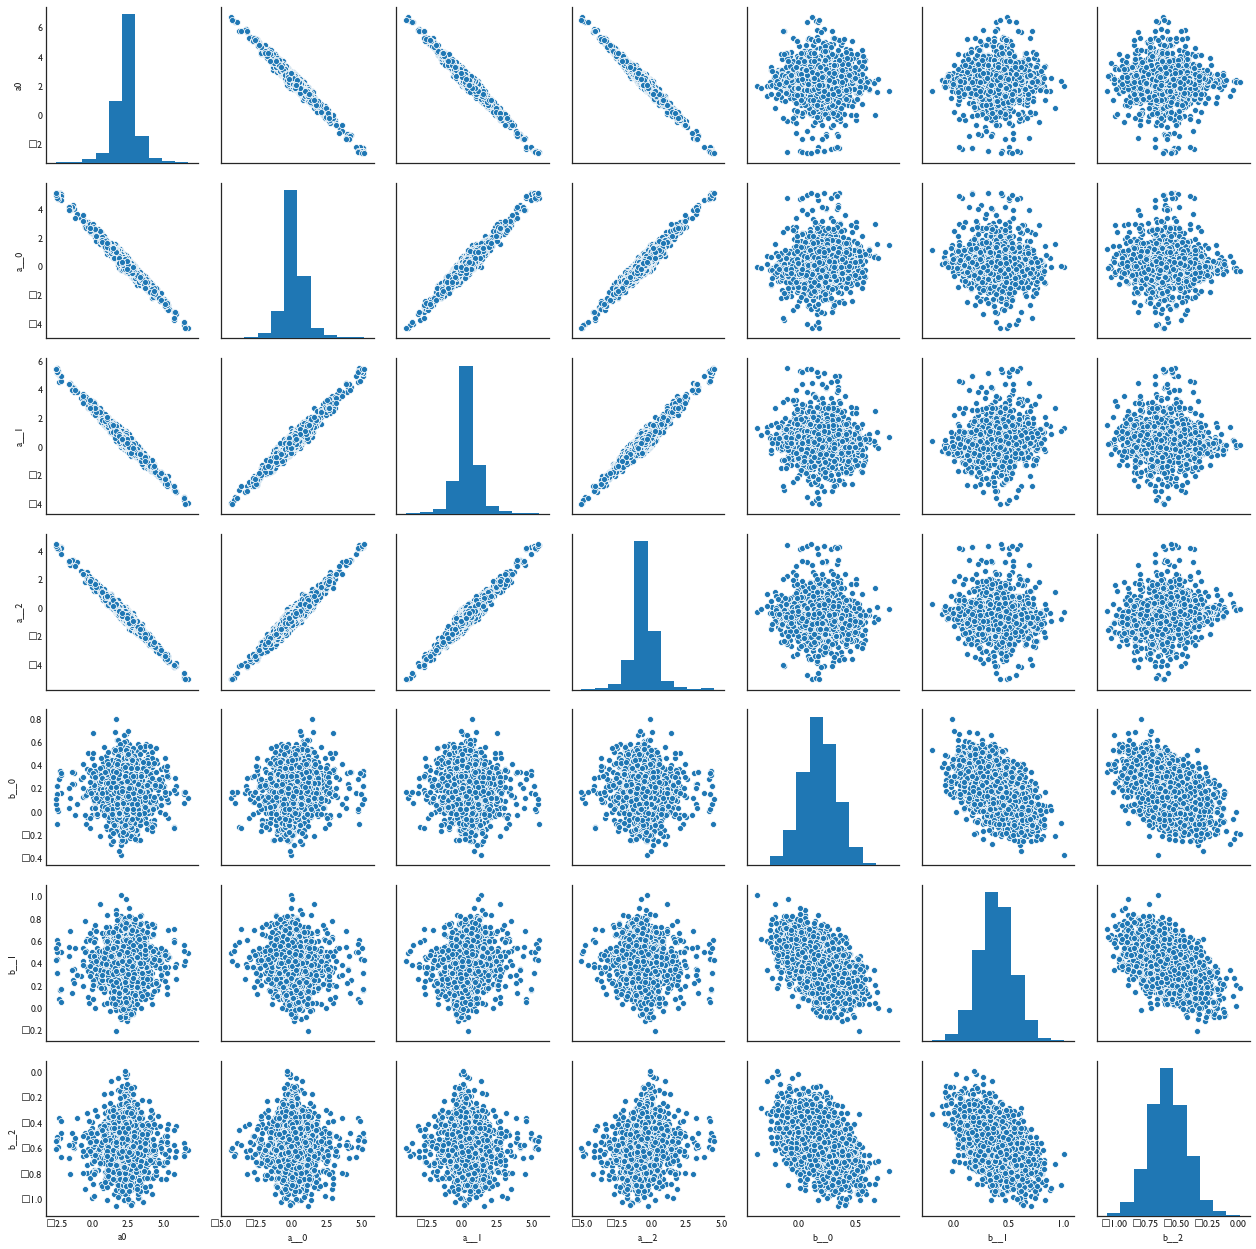

In [110]:
tracedf1 = pm.trace_to_dataframe(trace3, varnames=['a0', 'a', 'b'])
sb.pairplot(tracedf1);

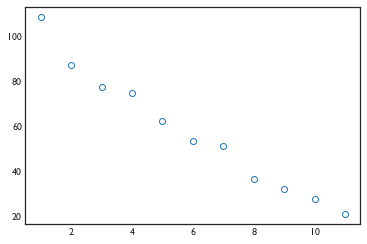

In [115]:
vals = np.array([model3.dict_to_array(v) for v in trace3[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = linalg.svd(vals)
sb.mpl.pyplot.plot(np.arange(1, len(S)+1), S, 'o', mfc='w', mew=1)

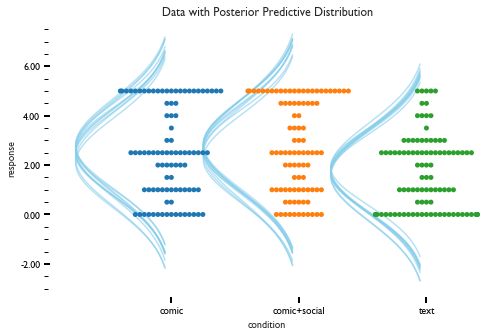

In [112]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = trace3['m'][:, 0]
social = trace3['m'][:, 1]
text = trace3['m'][:, 2]
scale = trace3['sigma'][:]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["comic", "comic+social", "text"],
    ax=ax)
ax.set_xlim(xmin=-1)

for i, grp in enumerate([comic, social, text]):
    sd = trace3['sigma'][:,i]
    plot_mustache(grp, sd, i, ax)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("data, with heterogenous varainces, robust, posterior predictions.pdf")

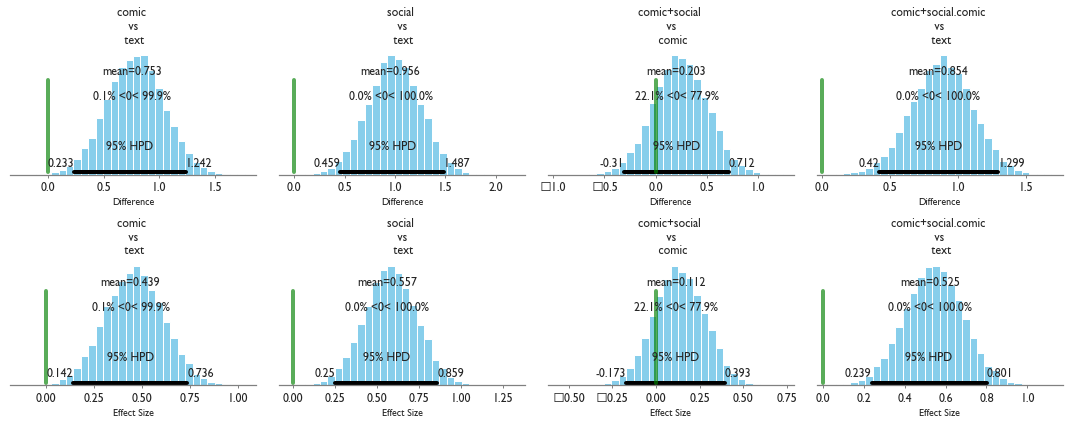

In [113]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

comic = trace3['m'][:, 0]
social = trace3['m'][:, 1]
text = trace3['m'][:, 2]
scale = trace3['sigma'][:]

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

cscale = np.zeros((len(comic), 4))
cscale[:, 0] = np.sqrt((scale[:, 0]**2 + scale[:, 2]**2) / 2)  # comic, text
cscale[:, 1] = np.sqrt((scale[:, 1]**2 + scale[:, 2]**2) / 2)  # social, text
cscale[:, 2] = np.sqrt((scale[:, 1]**2 + scale[:, 0]**2) / 2)  # social, comic

t = (scale[:, 1]**2 + scale[:, 0]**2
     ) / 4  # variance of mean of comic and social
cscale[:, 3] = np.sqrt(
    (t**2 + scale[:, 2]**2) / 2)  # variance of mean of comic and social, text

sd = [cscale[:,0],
      cscale[:,1],
      cscale[:,2],
      cscale[:,3]
]

contrast_titles = [
    'comic \n vs \n text', 
    'social \n vs \n text',
    'comic+social \n vs \n comic', 
    'comic+social.comic \n vs \n text'
]

for contr, csd, ctitle, ax_top, ax_bottom in zip(contrasts, sd, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_top)
    pm.plot_posterior(contr / csd, ref_val=0, color=color, ax=ax_bottom) # use this!!
#     pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()
fig.savefig("heterogenous variances, robust, case.pdf")

In [ ]:
scale.shape

## model code (sep. 2018)

In [ ]:
n_lambda = 1/29.0  # hyperprior parameter for nu
# m_mean = dfs.groupby('condition').mean().values
# m_sigma = dfs.groupby('condition').std().values


s_low = 0
s_high = 5
# case = dfs[dfs.condition < 2].condition # either 0, 1
# obs  = dfs[dfs.condition < 2].response # for conditions 0, 1

case = dfs.condition # either 0, 1, 2
obs  = dfs.response # for conditions 0, 1, 2
# obs  = 0.0001+0.999*(dfs.response)/5.0 # normalized response for conditions 0, 1, 2

with pm.Model() as group_main:

    mode = pm.Normal('mode', mu=m_mean/5.0, tau=1 / m_std**2, shape=3, testval=m_mean)
    deg_nu = pm.Exponential('nu', lam=n_lambda)  # shared
    sigma = pm.Uniform('sigma', lower=0, upper=5, shape=3)

    r = pm.StudentT('R_obs', observed=obs, nu=deg_nu, mu=mode[case], sd=sigma[case])

## model code (beta, feb. 2019)

In [ ]:
# n_lambda = 10.0 # hyperprior parameter for the exponential distribution

# s_low = 0
# s_high = 5
# # case = dfs[dfs.condition < 2].condition # either 0, 1
# # obs  = dfs[dfs.condition < 2].response # for conditions 0, 1

# case = dfs.condition # either 0, 1, 2
# obs  = 0.0001+0.999*(dfs.response)/5.0 # normalized response for conditions 0, 1, 2

# with pm.Model() as group_main:
#     a = pm.Exponential('alpha', lam=n_lambda, shape=3, testval=1) # the alpha parameter
#     b = pm.Exponential('beta', lam=n_lambda, shape=3, testval=1) # the beta parameter
    
# #     mode = pm.Normal('mode', mu=m_mean, tau=1 / m_std**2, shape=3)    
# #     sigma = pm.Uniform('sigma', lower=0, upper=5, shape=3)

# #     r = pm.Normal('R_obs',  observed=obs, mu=mode[case], sd=sigma[case])

#     r = pm.Beta('R_obs', observed=obs, alpha=a[case], beta=b[case])

In [ ]:
with group_main:
    trace = pm.sample(20000)

## diagnostics

In [ ]:
print(pm.diagnostics.gelman_rubin(trace))
print("effective sample size", pm.diagnostics.effective_n(trace))

In [ ]:
# import pickle #

# with open('ordinal_factor_model_main-noint.pkl', 'wb') as buff:
#     pickle.dump({'model': ordinal_factor_model_main, 'trace': trace}, buff)

# with open('my_model.pkl', 'rb') as buff:
#     data = pickle.load(buff)  

# basic_model, trace = data['model'], data['trace']

In [ ]:
# checking normality

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    trace['nu'],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=30,
    text_size=10,
    ax=axs)

z = axs
# s = "$\mu$"
z.set_xlabel("Degrees of Freedom")

center = trace['nu'].mean()
z.set_xlim([0, 3*center])
z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
# z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig.tight_layout()
fig.savefig("normality parameter.pdf")


In [ ]:
mode = trace['mode']
# nm = (b0 - 4) / sigma  # effect size

# plot theta posterior

NRows = 1  
NCols = 5  # three basic plots and two effect sizes
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot three posteriors
pm.plot_posterior(
    trace['mode'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    trace['mode'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    trace['mode'][:, 2],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[2],
    text_size=10)


# determining the effect size

mu0 = trace['mode'][:, 0]
mu1 = trace['mode'][:, 1]
mu2 = trace['mode'][:, 2]

sigma0 = trace['sigma'][:, 0]
sigma1 = trace['sigma'][:, 1]
sigma2 = trace['sigma'][:, 2]



effect10 = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)
effect21 = (mu2 - mu1)/np.sqrt((sigma1**2 + sigma2**2)/2.0)



for j in range(3):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    center = trace['mode'][:, j].mean()
    z.set_xlim([center - 1.5, center + 1.5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()


# first contrast: comic vs. text
pm.plot_posterior(
    effect10,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[3],
    text_size=10)

z = axs3[3]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect10.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()


# second contrast: comic vs. social
pm.plot_posterior(
    effect21,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[4],
    text_size=10)

z = axs3[4]
s = "$ (\mu_2 - \mu_1)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect21.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()




fig3.tight_layout()
fig3.savefig("new_exp_text_v_comic_v_social.pdf")


In [ ]:
pm.plot_posterior(
    sigma0,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    text_size=10)
pm.plot_posterior(
    sigma1,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    text_size=10)
pm.plot_posterior(
    sigma2,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    text_size=10)

In [ ]:
# Use LaTeX for typesetting
rc('text', usetex=True)
# Use ACM standard fonts (Type 1) for numbers and labels
rc('text.latex',
   preamble=[
       r'\usepackage[tt=false, type1=true]{libertine}',
       r'\usepackage[libertine]{newtxmath}', 
       r'\usepackage[varqu]{zi4}',
       r'\usepackage[T1]{fontenc}'
   ])

NRows = 3
NCols = 2
fig, axs = sb.mpl.pyplot.subplots(3, 2)
fig.set_size_inches(16, 8)
pm.plots.traceplot(
    trace=trace,
    varnames=['mode', 'sigma', 'nu'],
    ax=axs,
    lines={
        'mode': [mu0.mean(), mu1.mean(), mu2.mean()],
        'sigma': [sigma0.mean(), sigma1.mean(), sigma2.mean()],
        'nu': (trace['nu']).mean()
        }
    )

for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("") # no individual labels
        z.set_ylabel("")
        z.spines['right'].set_visible(False)
        z.spines['top'].set_visible(False)
        z.spines['left'].set_visible(False)
        z.spines['bottom'].set_visible(False)
        z.spines['bottom'].set_position(('outward', 10))
        z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
        z.minorticks_on()
        
axs[0,0].set_title(r'$\mu$')
axs[0,1].set_title(r'$\mu$')
axs[1,0].set_title(r'$\sigma$')
axs[1,1].set_title(r'$\sigma$')
axs[2,0].set_title(r'$\nu$')
axs[2,1].set_title(r'$\nu$')
fig.savefig('traceplot.pdf')


## using the Beta distribution (feb. 2019).

we need to transform the variables into mean and variance; $$\mu = \frac{\alpha}{\alpha + \beta}$$ and variance $$\sigma = \frac{\alpha \beta}{(\alpha + \beta)^2 (\alpha + \beta +1)}$$



In [ ]:
# determining the parameters first

alpha0 = trace['alpha'][:, 0]
alpha1 = trace['alpha'][:, 1]
alpha2 = trace['alpha'][:, 2]

beta0 = trace['beta'][:, 0]
beta1 = trace['beta'][:, 1]
beta2 = trace['beta'][:, 2]


# transforming them

mu0 = alpha0 / (alpha0 + beta0)
mu1 = alpha1 / (alpha1 + beta1)
mu2 = alpha2 / (alpha2 + beta2)

sigma0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 +1))
sigma1 = (alpha1 * beta1) / ((alpha1 + beta1)**2 * (alpha1 + beta1 +1))
sigma2 = (alpha2 * beta2) / ((alpha2 + beta2)**2 * (alpha2 + beta2 +1))

NRows = 1  
NCols = 5  # three basic plots and two effect sizes
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot three posteriors
pm.plot_posterior(
    mu0,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    mu1,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    mu2,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[2],
    text_size=10)

effect10 = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)
effect21 = (mu2 - mu1)/np.sqrt((sigma1**2 + sigma2**2)/2.0)


for j in range(3):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    z.set_xlim([0, 1])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()
    
    
# first contrast: comic vs. text
pm.plot_posterior(
    effect10,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[3],
    text_size=10)

z = axs3[3]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect10.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()


# second contrast: comic vs. social
pm.plot_posterior(
    effect21,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[4],
    text_size=10)

z = axs3[4]
s = "$ (\mu_2 - \mu_1)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect21.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig3.tight_layout()


## using the gamma distribution
avoids the artificial constraints of altering the data

In [ ]:
n_lambda = 1/10.0 # hyperprior parameter for the exponential distribution

s_low = 0
s_high = 5
# case = dfs[dfs.condition < 2].condition # either 0, 1
# obs  = dfs[dfs.condition < 2].response # for conditions 0, 1

case = dfs.condition # either 0, 1, 2
obs  = dfs.response + 0.001 # normalized response for conditions 0, 1, 2

with pm.Model() as group_main:
    a = pm.Exponential('alpha', lam=n_lambda, shape=3, testval=1) # the alpha shape parameter
    b = pm.Exponential('beta', lam=n_lambda, shape=3, testval=1) # the beta rate parameter
    r = pm.Gamma('R_obs', observed=obs, alpha=a[case], beta=b[case])

In [ ]:
with group_main:
    trace = pm.sample(10000)

In [ ]:
# determining the parameters first

alpha0 = trace['alpha'][:, 0]
alpha1 = trace['alpha'][:, 1]
alpha2 = trace['alpha'][:, 2]

beta0 = trace['beta'][:, 0]
beta1 = trace['beta'][:, 1]
beta2 = trace['beta'][:, 2]


# transforming shape and rate to mean and variance

mu0 = alpha0 / beta0
mu1 = alpha1 / beta1
mu2 = alpha2 / beta2

sigma0 = alpha0 / beta0**2
sigma1 = alpha1 / beta1**2
sigma2 = alpha2 / beta2**2

NRows = 1  
NCols = 5  # three basic plots and two effect sizes
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot three posteriors
pm.plot_posterior(
    mu0,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    mu1,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)
pm.plot_posterior(
    mu2,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[2],
    text_size=10)

effect10 = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)
effect21 = (mu2 - mu1)/np.sqrt((sigma1**2 + sigma2**2)/2.0)


for j in range(3):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    z.set_xlim([0, 5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()
    
    
# first contrast: comic vs. text
pm.plot_posterior(
    effect10,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[3],
    text_size=10)

z = axs3[3]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect10.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()


# second contrast: comic vs. social
pm.plot_posterior(
    effect21,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[4],
    text_size=10)

z = axs3[4]
s = "$ (\mu_2 - \mu_1)/\sqrt{(\sigma_1^2 + \sigma_2^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect21.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig3.tight_layout()



## differences between comic and comic social

In [ ]:
m_mean = np.zeros(2)
m_mean[0] = np.mean(dfs[dfs.condition==1].response)
m_mean[1] = np.mean(dfs[dfs.condition==2].response)

m_std = np.zeros(2)
m_std[0] = np.std(dfs[dfs.condition==1].response)
m_std[1] = np.std(dfs[dfs.condition==2].response)


n_lambda = 1/29.0  # hyperprior parameter for nu
# m_mean = dfs.groupby('condition').mean().values
# m_sigma = dfs.groupby('condition').std().values


s_low = 0
s_high = 5
case = dfs[dfs.condition > 0].condition - 1 # either 1, 2
obs  = dfs[dfs.condition > 0].response # for conditions 1,2

with pm.Model() as group_comic_v_social:

    mode = pm.Normal('mode', mu=m_mean, tau=1 / m_std**2, shape=2, testval=m_mean)
    deg_nu = pm.Exponential('nu', lam=n_lambda)  # shared
    sigma = pm.Uniform('sigma', lower=0, upper=5, shape=2)


    r = pm.StudentT('R_obs', observed=obs, nu=deg_nu, mu=mode[case], sd=sigma[case])

In [ ]:
with group_comic_v_social:
    trace = pm.sample(10000)

In [ ]:
pm.diagnostics.gelman_rubin(trace)

In [ ]:
pm.traceplot(trace=trace)

In [ ]:
mode = trace['mode']
# nm = (b0 - 4) / sigma  # effect size

# plot theta posterior

NRows = 1  
NCols = 3  # two basic plots and effect size
sb.set_style("white")
fig3, axs3 = sb.mpl.pyplot.subplots(NRows,
                                    NCols)  #### change on changing parameters
fig3.set_size_inches(NCols * 2, 2)

# Plot posteriors
pm.plot_posterior(
    trace['mode'][:, 0],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[0],
    text_size=10)
pm.plot_posterior(
    trace['mode'][:, 1],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ax=axs3[1],
    text_size=10)


# determining the effect size

mu0 = trace['mode'][:, 0]
mu1 = trace['mode'][:, 1]

sigma0 = trace['sigma'][:, 0]
sigma1 = trace['sigma'][:, 1]

effect = (mu1 - mu0)/np.sqrt((sigma0**2 + sigma1**2)/2.0)

for j in range(2):
    z = axs3[j]
    s = "$\\mu_{{{0}}}$".format(j)
    z.set_xlabel("{0}".format(s))
    center = trace['mode'][:, j].mean()
    z.set_xlim([center - 1.5, center + 1.5])

    z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
    z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
    z.xaxis.set_ticks_position('bottom')
    z.yaxis.set_ticks_position('left')
    z.minorticks_on()


pm.plot_posterior(
    effect,
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=0,
    ax=axs3[2],
    text_size=10)

z = axs3[2]
s = "$ (\mu_1 - \mu_0)/\sqrt{(\sigma_1^2 + \sigma_0^2)/2}$"
z.set_xlabel("{0}".format(s))
center = effect.mean()
z.set_xlim([center - 1.5, center + 1.5])

z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
z.yaxis.set_ticks_position('left')
z.minorticks_on()






fig3.tight_layout()
fig3.savefig("new_exp_comic_v_social.pdf")